# Clustering Task 3

# Importing Libraries

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import warnings # to remove warnings
warnings.filterwarnings("ignore")

# Pre-Processing
# RFM

In [23]:
customers_df = pd.read_csv("Customers.csv")
transactions_df = pd.read_csv("Transactions.csv")

customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])

transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])

last_transaction = transactions_df.groupby('CustomerID')['TransactionDate'].max().reset_index()
last_transaction['Recency'] = (pd.to_datetime('today') - last_transaction['TransactionDate']).dt.days

frequency = transactions_df.groupby('CustomerID')['TransactionID'].count().reset_index()
frequency.rename(columns={'TransactionID': 'Frequency'}, inplace=True)

monetary = transactions_df.groupby('CustomerID')['TotalValue'].sum().reset_index()
monetary.rename(columns={'TotalValue': 'Monetary'}, inplace=True)

# merging the features
customer_profile = customers_df[['CustomerID', 'Region']]
customer_rfm = pd.merge(last_transaction[['CustomerID', 'Recency']], frequency[['CustomerID', 'Frequency']], on='CustomerID')
customer_rfm = pd.merge(customer_rfm, monetary[['CustomerID', 'Monetary']], on='CustomerID')

customer_data = pd.merge(customer_profile, customer_rfm, on='CustomerID')

customer_data = pd.get_dummies(customer_data, columns=['Region'])

# feature engineering
customer_data['RecencyFrequencyRatio'] = customer_data['Recency'] / (customer_data['Frequency'] + 1)
customer_data['RecencyMonetaryRatio'] = customer_data['Recency'] / (customer_data['Monetary'] + 1)
customer_data['FrequencyMonetaryRatio'] = customer_data['Frequency'] / (customer_data['Monetary'] + 1)

# Log transformations

customer_data['LogMonetary'] = np.log1p(customer_data['Monetary'])
customer_data['LogFrequency'] = np.log1p(customer_data['Frequency'])


customer_data['NormRecency'] = (customer_data['Recency'] - customer_data['Recency'].min()) / (customer_data['Recency'].max() - customer_data['Recency'].min())


features = customer_data[['LogMonetary', 'LogFrequency', 'NormRecency', 
                          'RecencyFrequencyRatio', 'RecencyMonetaryRatio', 
                          'FrequencyMonetaryRatio'] + [col for col in customer_data.columns if 'Region' in col]]

# Clustering (K-Means) and Determining Optimal Clusters

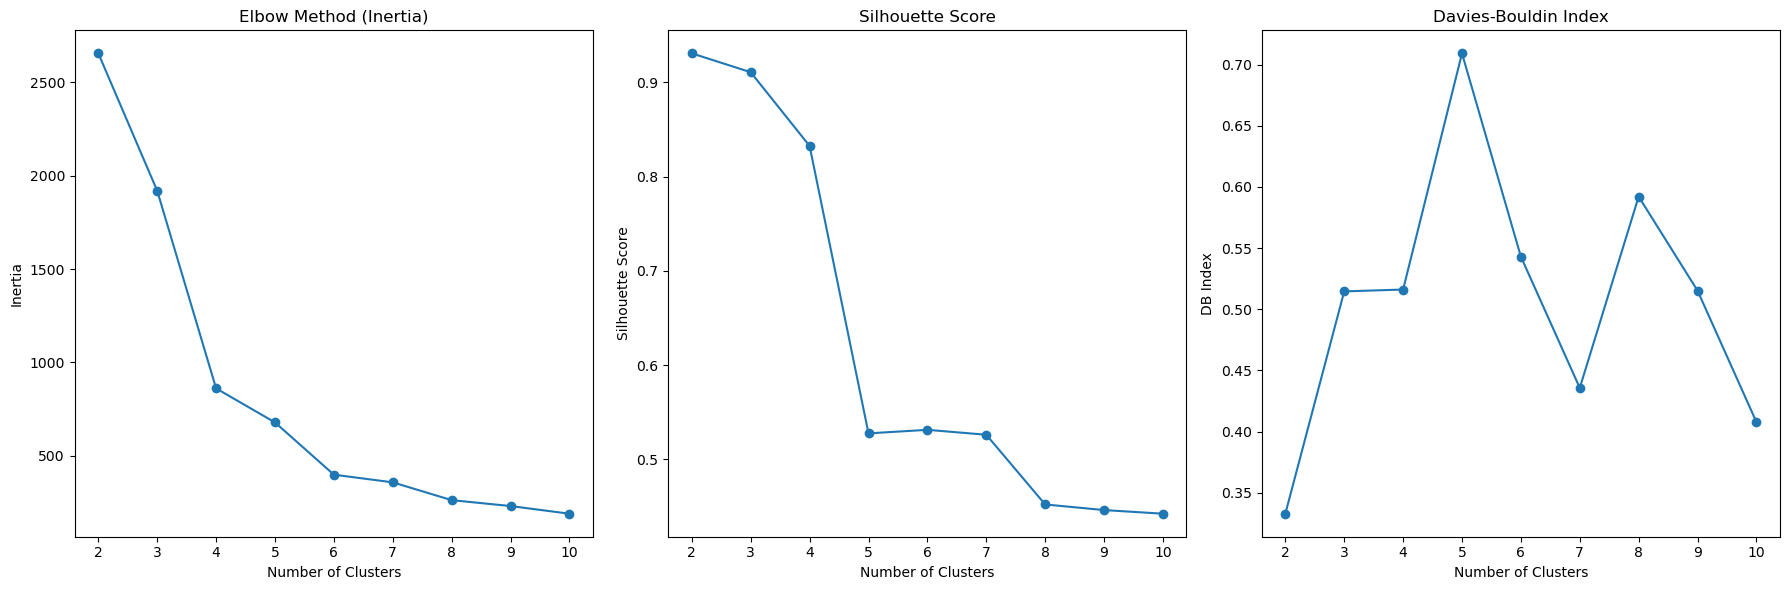


 Optimal number of clusters: 4

 DB Index: 0.5160644633752305

 Silhouette Score: 0.8326502307852304


In [25]:
scaler = RobustScaler()
scaled_data = scaler.fit_transform(features)

# Dimensiona reduction
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)


inertia = []
sil_scores = []
db_indexes = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(reduced_data)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(reduced_data, kmeans.labels_))
    db_indexes.append(davies_bouldin_score(reduced_data, kmeans.labels_))


# plotting
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method (Inertia)')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

plt.subplot(1, 3, 2)
plt.plot(range(2, 11), sil_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.subplot(1, 3, 3)
plt.plot(range(2, 11), db_indexes, marker='o')
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')

plt.tight_layout()
plt.show()

optimal_k = 4 # no of clusters(optimal)

kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
kmeans.fit(reduced_data)

customer_data['Cluster'] = kmeans.labels_

db_index = davies_bouldin_score(reduced_data, kmeans.labels_)
silhouette = silhouette_score(reduced_data, kmeans.labels_)

print(f"\n Optimal number of clusters: {optimal_k}")
print(f"\n DB Index: {db_index}")
print(f"\n Silhouette Score: {silhouette}")

# Visualizing the Clusters

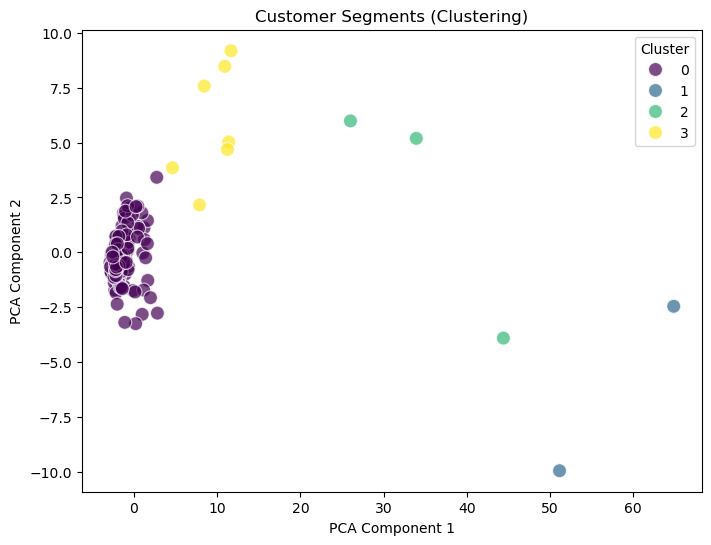

In [27]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data)

# Plotting
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=customer_data['Cluster'], palette='viridis', s=100, alpha=0.7)
plt.title('Customer Segments (Clustering)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster', loc='upper right')
plt.show()
